In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import scipy.stats as stats
plt.rcParams['figure.figsize'] = (16, 9)
plt.rcParams['font.size'] = 9
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.labelsize'] = plt.rcParams['font.size']
plt.rcParams['axes.titlesize'] = 1.5*plt.rcParams['font.size']
plt.rcParams['legend.fontsize'] = plt.rcParams['font.size']
plt.rcParams['xtick.labelsize'] = plt.rcParams['font.size']
plt.rcParams['ytick.labelsize'] = plt.rcParams['font.size']
plt.rcParams['savefig.dpi'] = 600
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.loc'] = 'center left'
plt.rcParams['axes.linewidth'] = 1
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 2

# HP3 data

reading the HP3 data. 
1. Tests in the HP3 data are manually re-coded into 1, 0 for a confirmation similarly done for the species dataset
2. Merge IUCN database to match the species names with common names and order 
3. Virus confrimed  == 1

In [2]:
data_path = 'C:\Users\Falco\Desktop\directory\Missing_links_in_viral_host_communities\data'
output_path = 'C:\Users\Falco\Desktop\directory\Missing_links_in_viral_host_communities\outputs'
url = 'C:/Users/Falco/Desktop/directory/HP3/data/associations.csv'
df = pd.read_csv(url)
df.columns = ['Virus', 'ScientificName', 'Wild', 'most_specific_diagnostic_Test','DetectionQuality', 'reference_ID', 'Virus_Confirmed']
df['Virus'] = df['Virus'].str.replace('_',' ')
df['ScientificName'] = df['ScientificName'].str.replace('_',' ')
'''removing humans from database '''
#df = df[df.ScientificName != 'Homo sapiens']
df['Source'] = 'HP3'
df['ScientificName'].replace('Alopex lagopus', 'Vulpes lagopus', inplace=True)
df['ScientificName'].replace('Pseudalopex vetulus', 'Lycalopex vetulus', inplace=True)
IUCN = pd.read_csv(data_path+'\IUCN Mammals, Birds, Reptiles, and Amphibians.csv')
IUCN["ScientificName"] = IUCN["Genus"].map(str) +' '+IUCN["Species"]
IUCN['common_names'] = IUCN['Common names (Eng)']
IUCN = IUCN[['Order', 'Family', 'Genus', 'Species', 'ScientificName', 'common_names']]
df = pd.merge(df, IUCN, on='ScientificName', how='left')
df = df[df.Virus_Confirmed == 1]
df.columns = ['Virus', 'ScientificName', 'Wild', 'most_specific_diagnostic_Test','DetectionQuality', 'reference_ID', 'Virus_Confirmed',
              'Source', 'order', 'family', 'genus', 'species', 'common_names']
print(df.shape)
#df.head()

(1526, 13)


# Viral Spill data


1. Clean all the text remove characters, extra spaces 
2. Add humans as additional host for all zoonotic viruses

In [3]:
V = pd.read_csv(data_path+'\Species.csv', encoding='ISO-8859-1', low_memory=False)
V['ScientificName'] = V['ScientificName'].str.replace('[^\x00-\x7F]','')
V['viral_family'] = V.viral_family.str.replace('[^\x00-\x7F]','')
V['Source'] = 'EpiCenter'
for c in V.columns:
    if V[c].dtype == 'O':
        V[c] = V[c].str.replace('\\xa0', '')
        V[c] = V[c].str.replace('xa0', '')
        V[c] = V[c].str.replace('\\xf3', 'o')
        V[c] = V[c].str.replace('\\xe1', 'a')
        V[c] = V[c].str.replace('\\xe9', 'e')
        V[c] = V[c].str.replace('\\xe3', 'a')
        V[c] = V[c].str.strip()
        V[c] = V[c].str.replace('[^\x00-\x7F]','')
        V[c] = V[c].astype(str).values

In [4]:
c = pd.DataFrame(V.groupby('ScientificName')['Source'].count()).reset_index(0)
c.to_pickle(data_path+'\Species_list.pkl')

In [5]:

V = V[['reference_ID', 'domestic', 'order', 'family', 'genus', 'species', 'ScientificName', 'common_names', 
'Virus', 'viral_family', 'most_specific_diagnostic_Test', 'Virus_Confirmed', 'accession', 'Source']]


v_list = V.Virus.unique().tolist()
humans_epicenter = pd.DataFrame({'order': 'PRIMATES',
              'family': 'HOMINIDAE', 
              'genus': 'Homo',
              'species': 'sapiens',
              'Virus':v_list, 'ScientificName':'Homo sapiens', 'Virus_Confirmed':1})

V  = V.append(humans_epicenter, ignore_index = True)
print (V.shape)
V = V[V.Virus_Confirmed == 1]
print (V.shape)

(4204, 14)
(2539, 14)


C:\ProgramData\Anaconda2\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [6]:
V.domestic.value_counts()

nan    1579
0       541
1       313
Name: domestic, dtype: int64

In [7]:
genbank = pd.read_csv(data_path+'/genbank_data_for_network.csv')
genbank['reference_ID'] = 'genbank'
genbank['domestic'] = np.nan
genbank['Virus_Confirmed'] = 1
genbank['Source'] = 'genbank'
#genbank.drop('accession', axis=1, inplace= True)
genbank.drop('Unnamed: 0', axis=1, inplace= True)
genbank.columns  = ['Virus', 'ScientificName', 'accession', 'most_specific_diagnostic_Test', 'order', 'family', 'genus',
                    'species', 'common_names', 'viral_family', 'reference_ID', 'domestic', 'Virus_Confirmed', 'Source']

In [8]:
set(V.columns.tolist()).difference(set(genbank.columns.tolist()))

set()

In [9]:
set(genbank.columns.tolist()).difference(set(V.columns.tolist()))

set()

In [10]:
genbank.head()

,Virus,ScientificName,accession,most_specific_diagnostic_Test,order,family,genus,species,common_names,viral_family,reference_ID,domestic,Virus_Confirmed,Source
0,Alkhumra hemorrhagic fever virus,Homo sapiens,21,PCR,PRIMATES,HOMINIDAE,Homo,sapiens,Human,Flaviviridae,genbank,NaN,1,genbank
1,Allpahuayo mammarenavirus,Oecomys bicolor,3,PCR,RODENTIA,CRICETIDAE,Oecomys,bicolor,Bicolored Arboreal Rice Rat,Arenaviridae,genbank,NaN,1,genbank
2,Amur virus,Apodemus peninsulae,21,PCR,RODENTIA,MURIDAE,Apodemus,peninsulae,Korean Field Mouse,Hantaviridae,genbank,NaN,1,genbank
3,Amur virus,Homo sapiens,1,PCR,PRIMATES,HOMINIDAE,Homo,sapiens,Human,Hantaviridae,genbank,NaN,1,genbank
4,Amur virus,Micromys minutus,1,PCR,RODENTIA,MURIDAE,Micromys,minutus,"Eurasian Harvest Mouse, Harvest Mouse",Hantaviridae,genbank,NaN,1,genbank


In [11]:
len(genbank.Virus.unique())

113

# Merge HP3 and Viral Spill

In [12]:
print('shape of Viral data')
print(V.shape)
print('Shape of HP3 data')
print(df.shape)
print('shape of genbank data')
print(genbank.shape)
print('merging first two dataframe')
data_species = V.append(df, ignore_index = True)
print('shape of new dataframe')
print(data_species.shape)
data_species = data_species.append(genbank, ignore_index = True)
print('shape of new dataframe')
print(data_species.shape)

shape of Viral data
(2539, 14)
Shape of HP3 data
(1526, 13)
shape of genbank data
(764, 14)
merging first two dataframe
shape of new dataframe
(4065, 16)
shape of new dataframe
(4829, 16)


In [13]:
print('Contributions form sources')
print(data_species.Source.value_counts())
print('number of viruses')
print(len(data_species.Virus.unique()))
print('number of animal species')
print(len(data_species.ScientificName.unique()))

Contributions form sources
EpiCenter    2433
HP3          1526
genbank       764
Name: Source, dtype: int64
number of viruses
709
number of animal species
968


In [14]:
all_species = pd.DataFrame(data_species.ScientificName.unique())
all_species.columns= ['Species_name']

In [15]:
#all_species.to_csv('C:\Users\Falco\Desktop\directory\Link_Prediction\outputs\Species_names_for_cleaning.csv')

In [16]:
print ('removing duplicate virus names becasue of presence of VIRUS word at the end')
viruses = sorted(data_species.Virus.unique().tolist())
print(len(viruses))
new_v = []
for v in viruses:
    if v+ ' virus' in viruses:
        new_v.append(v+ ' virus')
        #print v+ ' virus'
    else:
        new_v.append(v)
print len(set(new_v))
virus_corrected = pd.DataFrame({'Virus':viruses, 'Virus_c':new_v})
data_species = pd.merge(data_species, virus_corrected, on='Virus', how='left')
data_species['virus_name'] = pd.np.where(data_species.Virus_c.str.contains("virus"), data_species.Virus_c, data_species.Virus_c+" virus")

removing duplicate virus names becasue of presence of VIRUS word at the end
709
641


In [17]:
sorted(data_species['virus_name'].unique().tolist())

['Adelaide River virus',
 'Adeno-associated virus-2',
 'Adeno-associated virus-5',
 'African green monkey polyomavirus',
 'African swine fever virus',
 'Aichi virus',
 'Alcelaphine herpesvirus 1',
 'Alcelaphine herpesvirus 2',
 'Aleutian mink disease virus',
 'Alkhumra hemorrhagic fever virus',
 'Alkhurma virus',
 'Allpaahuayo virus',
 'Allpahuayo mammarenavirus',
 'Amapari virus',
 'Amur virus',
 'Andes orthohantavirus',
 'Andes virus',
 'Anopheles A virus',
 'Anopheles B virus',
 'Apoi virus',
 'Araguari virus',
 'Aravan lyssavirus',
 'Aravan virus',
 'Arctic squirrel hepatitis virus',
 'Aroa virus',
 'Arumowot virus',
 'Ateline herpesvirus 1',
 'Ateline herpesvirus 2',
 'Australian bat lyssavirus',
 'BK polyomavirus',
 'Baboon orthoreovirus',
 'Bagaza virus',
 'Bakau virus',
 'Bangui virus',
 'Banna virus',
 'Banzi virus',
 'Barmah Forest virus',
 'Barmah forest virus',
 'Barur virus',
 'Batai virus',
 'Bayou orthohantavirus',
 'Bayou virus',
 'Bear Canyon mammarenavirus',
 'Bear Ca

In [18]:
data_species['virus_name'].isna().sum()

0

#### Cleaning some of the virus names

In [19]:
data_species.replace('Rio Mamore virus', 'Rio Mamore hantavirus', inplace = True)
data_species.replace('Seoul virus', 'Seoul orthohantavirus', inplace = True)
data_species.replace('Sin Nombre virus', 'Sin Nombre orthohantavirus', inplace = True)
data_species.replace('Tai Forest virus', 'Tai Forest ebolavirus', inplace = True)
data_species.replace('Thottapalayam virus', 'Thottapalayam orthohantavirus', inplace = True)
data_species.replace('Tonto Creek virus', 'Tonto creek virus', inplace = True)
data_species.replace('Torque Teno virus', 'Torque teno virus', inplace = True)
data_species.replace('Western equine encephalomyelitis virus', 'Western equine encephalitis virus', inplace = True)


data_species.replace('Alkhumra', 'Alkhumra hemorrhagic fever virus', inplace = True)
data_species.replace('Allpaahuayo virus', 'Allpahuayo mammarenavirus', inplace = True)

data_species.replace('Andes virus', 'Andes orthohantavirus', inplace = True)
data_species.replace('Bear Canyon virus', 'Bear Canyon mammarenavirus', inplace = True)
data_species.replace('Black Creek Canal virus', 'Black Creek Canal orthohantavirus', inplace = True)
data_species.replace('Bundibugyo virus', 'Bundibugyo ebolavirus', inplace = True)
data_species.replace('Dobrava-Belgrade virus', 'Dobrava-Belgrade orthohantavirus', inplace = True)
data_species.replace('Duvenhage virus', 'Duvenhage lyssavirus', inplace = True)
data_species.replace('El Moro Canyon virus', 'El Moro Canyon orthohantavirus', inplace = True)
data_species.replace('Hantaan virus', 'Hantaan orthohantavirus', inplace = True)

data_species.replace('Hendra virus', 'Hendra henipavirus', inplace = True)
data_species.replace('Irkut virus', 'Irkut lyssavirus', inplace = True)
data_species.replace('Isla Vista virus', 'Isla Vista hantavirus', inplace = True)
data_species.replace('Junin virus', 'Junin mammarenavirus', inplace = True)
data_species.replace('Lagos bat virus', 'Lagos bat lyssavirus', inplace = True)
data_species.replace('Laguna Negra virus', 'Laguna Negra orthohantavirus', inplace = True)
data_species.replace('Lassa virus', 'Lassa mammarenavirus', inplace = True)


data_species.replace('Lymphocytic choriomeningitis virus', 'Lymphocytic choriomeningitis mammarenavirus', inplace = True)
data_species.replace('Machupo virus', 'Machupo mammarenavirus', inplace = True)
data_species.replace('Mopeia virus', 'Mopeia mammarenavirus', inplace = True)
data_species.replace('New York virus', 'New York hantavirus', inplace = True)
data_species.replace('Nipah virus', 'Nipah henipavirus', inplace = True)
data_species.replace('Oliveros virus', 'Oliveros mammarenavirus', inplace = True)
data_species.replace('Pirital virus', 'Pirital mammarenavirus', inplace = True)
data_species.replace('Prospect Hill virus', 'Prospect Hill orthohantavirus', inplace = True)

data_species.replace('Forest', 'forest', inplace= True)
data_species.replace('Virus', 'virus', inplace= True)
data_species.replace('Kyasanur forest disease virus', 'Kyasanur forest virus', inplace= True)
data_species.replace('Cetacean morbillivirus virus', 'Cetacean morbillivirus', inplace= True)
data_species.replace('Valley', 'valley', inplace= True)
data_species.replace('-', ' ', inplace= True)
data_species.replace('Tickborne', 'Tick-borne', inplace= True)
data_species.replace('Encephalitis', 'encephalitis', inplace= True)
data_species.replace('Stomatitis', 'stomatitis', inplace= True)
data_species.replace('encephalomyelitis', 'encephalitis', inplace= True)
data_species.replace('Reston ebolavirus', 'Reston virus', inplace= True)
data_species.replace('Issyk Kul virus', 'Issyk-Kul virus', inplace= True)
data_species.replace('Juquitiba like virus', 'Juquitiba virus', inplace= True)
data_species.replace('dehydrogenase elevating', 'dehydrogenase-elevating', inplace= True)
data_species.replace('Pig tailed', 'Pig-tailed', inplace= True)
data_species.replace('T lymphotropic', 'T-lymphotropic', inplace= True)
data_species.replace('Tai Forest virus', 'Tai Forest ebolavirus', inplace= True)
data_species.replace('TT', 'Torque teno', inplace= True)

In [20]:
len(data_species.virus_name.unique())

608

In [21]:
data_species.head()

,DetectionQuality,ScientificName,Source,Virus,Virus_Confirmed,Wild,accession,common_names,domestic,family,genus,most_specific_diagnostic_Test,order,reference_ID,species,viral_family,Virus_c,virus_name
0,NaN,Accipiter cooperii,EpiCenter,West Nile,1,NaN,0,nan,nan,ACCIPITRIDAE,Accipiter,PRNT,Accipitriformes,113-ES-10,cooperii,Flaviviridae,West Nile virus,West Nile virus
1,NaN,Accipiter cooperii,EpiCenter,West Nile,1,NaN,AF206520,nan,nan,ACCIPITRIDAE,Accipiter,nucleotide,Accipitriformes,GENBANK,cooperii,Flaviviridae,West Nile virus,West Nile virus
2,NaN,Accipiter cooperii,EpiCenter,West Nile,1,NaN,HM756660,nan,nan,ACCIPITRIDAE,Accipiter,nucleotide,Accipitriformes,GENBANK,cooperii,Flaviviridae,West Nile virus,West Nile virus
3,NaN,Accipiter gentilis,EpiCenter,West Nile,1,NaN,GU566739,nan,nan,ACCIPITRIDAE,Accipiter,nucleotide,Accipitriformes,GENBANK,gentilis,Flaviviridae,West Nile virus,West Nile virus
4,NaN,Accipiter gentilis,EpiCenter,West Nile,1,NaN,HM015884,nan,nan,ACCIPITRIDAE,Accipiter,nucleotide,Accipitriformes,GENBANK,gentilis,Flaviviridae,West Nile virus,West Nile virus


In [22]:
data_species.columns.tolist()

['DetectionQuality',
 u'ScientificName',
 'Source',
 u'Virus',
 u'Virus_Confirmed',
 'Wild',
 u'accession',
 u'common_names',
 u'domestic',
 u'family',
 u'genus',
 u'most_specific_diagnostic_Test',
 u'order',
 u'reference_ID',
 u'species',
 u'viral_family',
 'Virus_c',
 'virus_name']

## Final virus database

In [23]:
virus_df = pd.read_csv('C:/Users/Falco/Desktop/directory/Missing_links_in_viral_host_communities/data/virus_df_final.csv')

In [24]:
virus_df.columns.tolist()

['Unnamed: 0',
 'Class',
 'Family',
 'Genome Composition',
 'Genus',
 'Kingdom',
 'Last Change',
 'MSL of Last Change',
 'Order',
 'Phylum',
 'Proposal for Last Change ',
 'PubMed_Search',
 'PubMed_Search_ln',
 'Realm',
 'Sort',
 'Species',
 'Subclass',
 'Subfamily',
 'Subgenus',
 'Subkingdom',
 'Suborder',
 'Subphylum',
 'Subrealm',
 'Taxon History URL',
 'Type Species?',
 'family',
 'genus',
 'hits',
 'hits_ln',
 'number_of hosts',
 'number_of hosts_x',
 'number_of hosts_y',
 'order',
 'species',
 'tax_id',
 'tax_id_n',
 'virus_name']

In [25]:
virus_df.drop(columns=['Unnamed: 0', 'number_of hosts_x', 'number_of hosts_y'], axis=1, inplace= True)

In [26]:
virus_df.head()

,Class,Family,Genome Composition,Genus,Kingdom,Last Change,MSL of Last Change,Order,Phylum,Proposal for Last Change,...,family,genus,hits,hits_ln,number_of hosts,order,species,tax_id,tax_id_n,virus_name
0,Monjiviricetes,Rhabdoviridae,ssRNA(-),Ephemerovirus,NaN,"Moved,",33.0,Mononegavirales,Negarnaviricota,2017.006M.A.v2.Negarnaviricota.zip,...,Rhabdoviridae,Ephemerovirus,10,2.302685,1,Mononegavirales,Adelaide River ephemerovirus,31612,31612,Adelaide River virus
1,NaN,Parvoviridae,ssDNA(+/-),Dependoparvovirus,NaN,"New,",28.0,NaN,NaN,2013.001a-aaaV.A.v4.Parvoviridae.pdf,...,Parvoviridae,Dependoparvovirus,546,6.302621,1,NaN,Adeno-associated dependoparvovirus A,10804,10804,Adeno-associated virus-2
2,NaN,Parvoviridae,ssDNA(+/-),Dependoparvovirus,NaN,"New,",28.0,NaN,NaN,2013.001a-aaaV.A.v4.Parvoviridae.pdf,...,Parvoviridae,Dependoparvovirus,43,3.761223,1,NaN,Adeno-associated dependoparvovirus B,82300,82300,Adeno-associated virus-5
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Polyomaviridae,NaN,25,3.218916,1,NaN,African green monkey polyomavirus,12480,12480,African green monkey polyomavirus
4,NaN,Asfarviridae,dsDNA,Asfivirus,NaN,"Moved,",17.0,NaN,NaN,Ratification_1998.pdf,...,Asfarviridae,Asfivirus,3837,8.252446,3,NaN,African swine fever virus,10497,10497,African swine fever virus


In [27]:
virus_df.columns =['Viral_Class',
                   'Viral_Family',
                   'Genome Composition',
                   'Viral_Genus',
                   'Viral_Kingdom',
                   'Last Change',
                   'MSL of Last Change',
                   'Viral_Order',
                   'Viral_Phylum',
                   'Proposal for Last Change ',
                   'PubMed_Search',
                   'PubMed_Search_ln',
                   'Realm',
                   'Sort',
                   'Viral_Species',
                   'Viral_Subclass',
                   'Viral_Subfamily',
                   'Viral_Subgenus',
                   'Viral_Subkingdom',
                   'Viral_Suborder',
                   'Viral_Subphylum',
                   'Viral_Subrealm',
                   'Taxon History URL',
                   'Type Species?',
                   'Viral_family',
                   'Viral_genus',
                   'hits',
                   'hits_ln',
                   'number_of_hosts',
                   'Viral_order',
                   'Viral_species',
                   'tax_id',
                   'tax_id_n',
                   'virus_name']

In [28]:
virus_df.head()

,Viral_Class,Viral_Family,Genome Composition,Viral_Genus,Viral_Kingdom,Last Change,MSL of Last Change,Viral_Order,Viral_Phylum,Proposal for Last Change,...,Viral_family,Viral_genus,hits,hits_ln,number_of_hosts,Viral_order,Viral_species,tax_id,tax_id_n,virus_name
0,Monjiviricetes,Rhabdoviridae,ssRNA(-),Ephemerovirus,NaN,"Moved,",33.0,Mononegavirales,Negarnaviricota,2017.006M.A.v2.Negarnaviricota.zip,...,Rhabdoviridae,Ephemerovirus,10,2.302685,1,Mononegavirales,Adelaide River ephemerovirus,31612,31612,Adelaide River virus
1,NaN,Parvoviridae,ssDNA(+/-),Dependoparvovirus,NaN,"New,",28.0,NaN,NaN,2013.001a-aaaV.A.v4.Parvoviridae.pdf,...,Parvoviridae,Dependoparvovirus,546,6.302621,1,NaN,Adeno-associated dependoparvovirus A,10804,10804,Adeno-associated virus-2
2,NaN,Parvoviridae,ssDNA(+/-),Dependoparvovirus,NaN,"New,",28.0,NaN,NaN,2013.001a-aaaV.A.v4.Parvoviridae.pdf,...,Parvoviridae,Dependoparvovirus,43,3.761223,1,NaN,Adeno-associated dependoparvovirus B,82300,82300,Adeno-associated virus-5
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Polyomaviridae,NaN,25,3.218916,1,NaN,African green monkey polyomavirus,12480,12480,African green monkey polyomavirus
4,NaN,Asfarviridae,dsDNA,Asfivirus,NaN,"Moved,",17.0,NaN,NaN,Ratification_1998.pdf,...,Asfarviridae,Asfivirus,3837,8.252446,3,NaN,African swine fever virus,10497,10497,African swine fever virus


#### Merging of viral data base with species database

In [29]:
data_species.shape

(4829, 18)

In [30]:
data_species2 = pd.merge(data_species, virus_df, on ='virus_name', how = 'left')

In [31]:
data_species.shape

(4829, 18)

In [32]:
data_species2.shape

(4829, 51)

In [33]:
data_species2.columns.tolist()

['DetectionQuality',
 u'ScientificName',
 'Source',
 u'Virus',
 u'Virus_Confirmed',
 'Wild',
 u'accession',
 u'common_names',
 u'domestic',
 u'family',
 u'genus',
 u'most_specific_diagnostic_Test',
 u'order',
 u'reference_ID',
 u'species',
 u'viral_family',
 'Virus_c',
 'virus_name',
 'Viral_Class',
 'Viral_Family',
 'Genome Composition',
 'Viral_Genus',
 'Viral_Kingdom',
 'Last Change',
 'MSL of Last Change',
 'Viral_Order',
 'Viral_Phylum',
 'Proposal for Last Change ',
 'PubMed_Search',
 'PubMed_Search_ln',
 'Realm',
 'Sort',
 'Viral_Species',
 'Viral_Subclass',
 'Viral_Subfamily',
 'Viral_Subgenus',
 'Viral_Subkingdom',
 'Viral_Suborder',
 'Viral_Subphylum',
 'Viral_Subrealm',
 'Taxon History URL',
 'Type Species?',
 'Viral_family',
 'Viral_genus',
 'hits',
 'hits_ln',
 'number_of_hosts',
 'Viral_order',
 'Viral_species',
 'tax_id',
 'tax_id_n']

In [34]:
['DetectionQuality',
 'ScientificName',
 'Source',
 'Virus',
 'Virus_Confirmed',
 'Wild',
 'accession',
 'common_names',
 'domestic',
 'host_family',
 'host_genus',
 'most_specific_diagnostic_Test',
 'host_order',
 'reference_ID',
 'host_species',
 'viral_family',
 'virus_name_corrections',
 'virus_name',
 'tax_id',
 'hits',
 'Pubmed_Search',
 'hits_ln',
 'PubMed_Search_ln',
 'tax_id_n',
 'viral_order',
 'viral_family_pubmed',
 'viral_genus',
 'viral_species_pubmed']

['DetectionQuality',
 'ScientificName',
 'Source',
 'Virus',
 'Virus_Confirmed',
 'Wild',
 'accession',
 'common_names',
 'domestic',
 'host_family',
 'host_genus',
 'most_specific_diagnostic_Test',
 'host_order',
 'reference_ID',
 'host_species',
 'viral_family',
 'virus_name_corrections',
 'virus_name',
 'tax_id',
 'hits',
 'Pubmed_Search',
 'hits_ln',
 'PubMed_Search_ln',
 'tax_id_n',
 'viral_order',
 'viral_family_pubmed',
 'viral_genus',
 'viral_species_pubmed']

In [35]:
data_species2.columns = ['DetectionQuality',
                         'ScientificName',
                         'Source',
                         'Virus',
                         'Virus_Confirmed',
                         'Wild',
                         'accession',
                         'common_names',
                         'domestic',
                         'host_family',
                         'host_genus',
                         'most_specific_diagnostic_Test',
                         'host_order',
                         'reference_ID',
                         'host_species',
                         'viral_family',
                         'virus_name_corrections',
                         'virus_name',
                         'viral_class',
                         'viral_family',
                         'genome_composition',
                         'viral_genus',
                         'viral_kingdom',
                         'last_change',
                         'MSL_of_last_change',
                         'viral_order',
                         'viral_phylum',
                         'proposal_for_last_change ',
                         'PubMed_Search',
                         'PubMed_Search_ln',
                         'viral_realm',
                         'Sort',
                         'viral_species',
                         'viral_subclass',
                         'viral_subfamily',
                         'viral_subgenus',
                         'viral_subkingdom',
                         'viral_suborder',
                         'viral_subphylum',
                         'viral_subrealm',
                         'taxon_history_URL',
                         'type_species',
                         'family',
                         'genus',
                         'hits',
                         'hits_ln',
                         'number_of_hosts',
                         'order',
                         'species',
                         'tax_id',
                         'tax_id_n']

In [36]:
data_species2['host_order'] = data_species2.host_order.str.title()
data_species2['host_family'] = data_species2.host_family.str.title()
data_species2['host_genus'] = data_species2.host_genus.str.title()
data_species2.replace('Primate', 'Primates', inplace = True)
data_species2.replace('Furnaridae', 'Furnariidae', inplace = True)
data_species2.replace('Psittacilidae', 'Psittaculidae', inplace = True)

In [37]:
data_species2.head()

,DetectionQuality,ScientificName,Source,Virus,Virus_Confirmed,Wild,accession,common_names,domestic,host_family,...,type_species,family,genus,hits,hits_ln,number_of_hosts,order,species,tax_id,tax_id_n
0,NaN,Accipiter cooperii,EpiCenter,West Nile,1,NaN,0,nan,nan,Accipitridae,...,0.0,Flaviviridae,Flavivirus,21421.0,9.972127,1126.0,NaN,West Nile virus,11082.0,11082.0
1,NaN,Accipiter cooperii,EpiCenter,West Nile,1,NaN,AF206520,nan,nan,Accipitridae,...,0.0,Flaviviridae,Flavivirus,21421.0,9.972127,1126.0,NaN,West Nile virus,11082.0,11082.0
2,NaN,Accipiter cooperii,EpiCenter,West Nile,1,NaN,HM756660,nan,nan,Accipitridae,...,0.0,Flaviviridae,Flavivirus,21421.0,9.972127,1126.0,NaN,West Nile virus,11082.0,11082.0
3,NaN,Accipiter gentilis,EpiCenter,West Nile,1,NaN,GU566739,nan,nan,Accipitridae,...,0.0,Flaviviridae,Flavivirus,21421.0,9.972127,1126.0,NaN,West Nile virus,11082.0,11082.0
4,NaN,Accipiter gentilis,EpiCenter,West Nile,1,NaN,HM015884,nan,nan,Accipitridae,...,0.0,Flaviviridae,Flavivirus,21421.0,9.972127,1126.0,NaN,West Nile virus,11082.0,11082.0


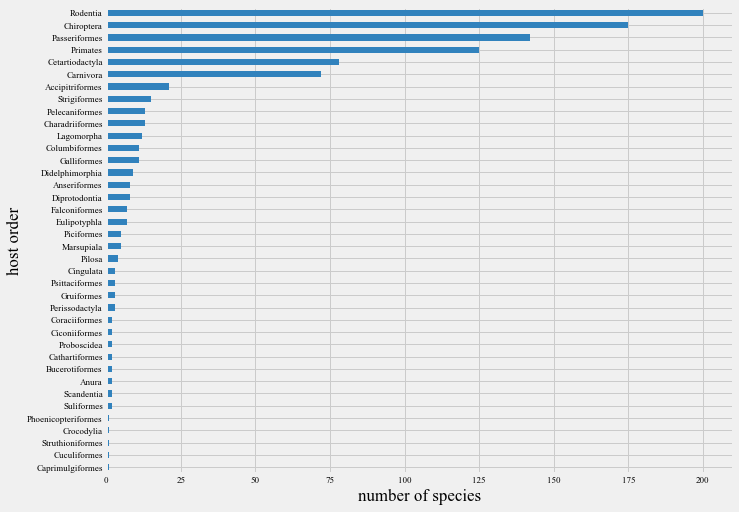

In [38]:
import matplotlib.style as style
style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1
#plt.rcParams[ti]
dpi = 1000
plt.rcParams['font.family'] = 'Times New Roman'
fig, ax1 = plt.subplots(figsize=(10,8))
data_species2.groupby('host_order').ScientificName.nunique().sort_values().plot(kind='barh', color = '#3182bd', ax = ax1)
plt.xlabel('number of species')
plt.ylabel('host order')
plt.show()

## Saving the dataframe for modelling

In [39]:
data_species2.to_pickle(data_path+'\species_hp_updated.pickle')

In [40]:
data_species2.shape

(4829, 51)

In [41]:
data_species2[data_species2.host_order.isna()]

,DetectionQuality,ScientificName,Source,Virus,Virus_Confirmed,Wild,accession,common_names,domestic,host_family,...,type_species,family,genus,hits,hits_ln,number_of_hosts,order,species,tax_id,tax_id_n


In [42]:
data_species2.columns

Index([u'DetectionQuality', u'ScientificName', u'Source', u'Virus',
       u'Virus_Confirmed', u'Wild', u'accession', u'common_names', u'domestic',
       u'host_family', u'host_genus', u'most_specific_diagnostic_Test',
       u'host_order', u'reference_ID', u'host_species', u'viral_family',
       u'virus_name_corrections', u'virus_name', u'viral_class',
       u'viral_family', u'genome_composition', u'viral_genus',
       u'viral_kingdom', u'last_change', u'MSL_of_last_change', u'viral_order',
       u'viral_phylum', u'proposal_for_last_change ', u'PubMed_Search',
       u'PubMed_Search_ln', u'viral_realm', u'Sort', u'viral_species',
       u'viral_subclass', u'viral_subfamily', u'viral_subgenus',
       u'viral_subkingdom', u'viral_suborder', u'viral_subphylum',
       u'viral_subrealm', u'taxon_history_URL', u'type_species', u'family',
       u'genus', u'hits', u'hits_ln', u'number_of_hosts', u'order', u'species',
       u'tax_id', u'tax_id_n'],
      dtype='object')

In [43]:
#data_species2.groupby('virus_name')['species'].count().to_csv(data_path+'/viral_df.csv')

In [44]:
#pd.read_pickle(data_path+'\species_hp.pickle').columns.tolist()